## **M&A NETWORK ANALYSIS**

## **Import Libraries and Data**

In [ ]:
# import essential libraries

%%capture
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
import community.community_louvain as community_louvain

sns.set()

In [ ]:
# install the visualization libraries and backend

%%capture
!pip install -qq holoviews
!pip install -qq -U bokeh
!pip install -qq datashader

# import the visualization libraries and backend

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show
kwargs = dict(width=800, height=800, xaxis=None, yaxis=None)
opts.defaults(opts.Nodes(**kwargs), opts.Graph(**kwargs))
from holoviews.operation.datashader import datashade, bundle_graph

In [ ]:
# load and process data
df = pd.read_excel('/content/Kering M&A Deals.xlsx', sheet_name = "madl249")

df.head()

,Deal Type,Announce Date,Target Name,Acquirer Name,Seller Name,Announced Total Value (mil.),Payment Type,TV/EBITDA,Deal Status
0,INV,2021-09-23,Commerce Media Holdings LLC,"Foot Locker Inc,Kering SA,Live Nation Entertai...",NaN,50.00,Cash,,Completed
1,M&A,2021-07-08,Lindberg A/S,Kering SA,NaN,NaN,Undisclosed,,Completed
2,INV,2021-06-24,Cocoon Ltd,"Kering SA,Private Investor",NaN,3.49,Cash,,Completed
3,INV,2021-06-24,Life In The Cocoon Ltd,Kering SA,NaN,NaN,Cash,,Completed
4,M&A,2021-05-16,"Girard-Perregaux,Ulysse Nardin",Potential Buyer,Kering SA,NaN,Cash,,Proposed


In [ ]:
#filtering types
wrong_types = ["JV", "SPIN"]

#drop rows that contain any value in the list
df = df[df["Deal Type"].isin(wrong_types) == False]

In [ ]:
#keep only relevant columns 
df.drop(columns=['Seller Name', 'TV/EBITDA'], axis=1, inplace=True)

In [ ]:
#rename columns
df.rename(columns={"Deal Type": "type", "Announce Date": "date",
                   "Target Name": "target", "Acquirer Name": "acquirer",
                   "Announced Total Value (mil.)": "value", "Payment Type": "payment",
                   "Deal Status": "status"}, inplace=True)

In [ ]:
#set acquirer name: we are just interested by Kering
df = df[df['acquirer'].str.contains("Kering") == True]
df['acquirer'] = "Kering SA"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#df['value'].fillna(0, inplace = True)

In [ ]:
df.head()

,type,date,target,acquirer,value,payment,status
0,INV,2021-09-23,Commerce Media Holdings LLC,Kering SA,50.00,Cash,Completed
1,M&A,2021-07-08,Lindberg A/S,Kering SA,NaN,Undisclosed,Completed
2,INV,2021-06-24,Cocoon Ltd,Kering SA,3.49,Cash,Completed
3,INV,2021-06-24,Life In The Cocoon Ltd,Kering SA,NaN,Cash,Completed
5,INV,2021-03-01,Vestiaire Collective SA,Kering SA,214.33,Cash,Completed


In [ ]:
#check the null values
df.isnull().sum()

type         0
date         0
target       0
acquirer     0
value       28
payment      0
status       0
dtype: int64

In [ ]:
#look at the null value

#df[df['Payment Type'].isnull()]

In [ ]:
#set the payment type, after checking the df its cash

#df['Payment Type'].fillna("Cash", inplace = True)

In [ ]:
#check again
#df.isnull().sum()

In [ ]:
df['payment'].value_counts()

Undisclosed       27
Cash              22
Stock              2
Cash and Stock     1
Name: payment, dtype: int64

In [ ]:
df['status'].value_counts()

Completed    51
Withdrawn     1
Name: status, dtype: int64

In [ ]:
#chech the duplicates
df[df['target'].duplicated() == True]

,type,date,target,acquirer,value,payment,status
6,INV,2020-04-21,Vestiaire Collective SA,Kering SA,63.98,Cash,Completed
53,M&A,2007-04-10,Puma SE,Kering SA,1948.27,Cash,Completed
75,M&A,2001-09-10,Kering Holland NV,Kering SA,1158.43,Cash,Completed
81,M&A,2000-09-06,Emmezeta Tanmac Srl,Kering SA,NaN,Undisclosed,Completed
90,INV,1999-03-19,Kering Holland NV,Kering SA,2914.20,Cash,Completed
94,INV,1998-02-20,Fullbeauty Brands Inc,Kering SA,408.56,Cash,Completed
95,M&A,1998-01-22,Guilbert France SA,Kering SA,775.97,Cash and Stock,Completed


In [ ]:
#drop duplicates
df.drop_duplicates(subset=['target'], inplace=True)

In [ ]:
df.head()

,type,date,target,acquirer,value,payment,status
0,INV,2021-09-23,Commerce Media Holdings LLC,Kering SA,50.00,Cash,Completed
1,M&A,2021-07-08,Lindberg A/S,Kering SA,NaN,Undisclosed,Completed
2,INV,2021-06-24,Cocoon Ltd,Kering SA,3.49,Cash,Completed
3,INV,2021-06-24,Life In The Cocoon Ltd,Kering SA,NaN,Cash,Completed
5,INV,2021-03-01,Vestiaire Collective SA,Kering SA,214.33,Cash,Completed


## **Initiate Networks and Nodes**

In [ ]:
# initiate network

g = nx.from_pandas_edgelist(df, 'target', 'acquirer')

In [ ]:
attributes = df.iloc[:, [0, 1, 2, 4, 5]]

In [ ]:
# set nodes characteristics

node_attr = attributes.set_index('target').to_dict('index')

nx.set_node_attributes(g, node_attr)

In [ ]:
g.nodes(data=True)['Kering Holland NV']

{'date': Timestamp('2003-10-03 00:00:00'),
 'payment': 'Cash',
 'type': 'M&A',
 'value': 2840.15}

In [ ]:
#clustering
partition = community_louvain.best_partition(g)

In [ ]:
nx.set_node_attributes(g, partition, 'partition')

In [ ]:
nodes_df = pd.DataFrame.from_dict(dict(g.nodes(data=True)),orient='index')

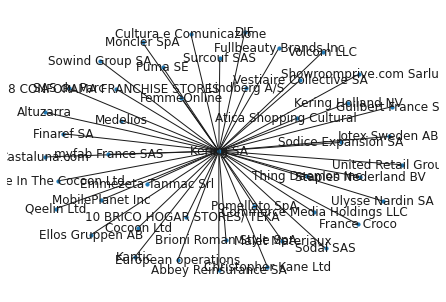

In [ ]:
#first representation
nx.draw(g, with_labels = True, node_size=10)

In [ ]:
# create and save a layout
g_layout = nx.layout.spring_layout(g) 
g_plot = hv.Graph.from_networkx(g, g_layout).opts(tools=['hover'], node_color='partition')
labels = hv.Labels(g_plot.nodes, ['x', 'y'], 'index')

# plot the network
bundled = bundle_graph(g_plot)
show(hv.render(bundled * labels.opts(text_font_size='6pt', text_color='white', bgcolor='gray')))

## **Direct Networks**

In [ ]:
df.head()

,type,date,target,acquirer,value,payment,status
0,INV,2021-09-23,Commerce Media Holdings LLC,Kering SA,50.00,Cash,Completed
1,M&A,2021-07-08,Lindberg A/S,Kering SA,NaN,Undisclosed,Completed
2,INV,2021-06-24,Cocoon Ltd,Kering SA,3.49,Cash,Completed
3,INV,2021-06-24,Life In The Cocoon Ltd,Kering SA,NaN,Cash,Completed
5,INV,2021-03-01,Vestiaire Collective SA,Kering SA,214.33,Cash,Completed


In [ ]:
 edge_df = list(zip(df['target'], df['acquirer']))

In [ ]:
dig = nx.DiGraph()

In [ ]:
dig.add_edges_from(edge_df, color='black')

In [ ]:
node_list = attributes
node_attr = node_list.set_index('target').to_dict('index')

In [ ]:
nx.set_node_attributes(dig, node_attr)

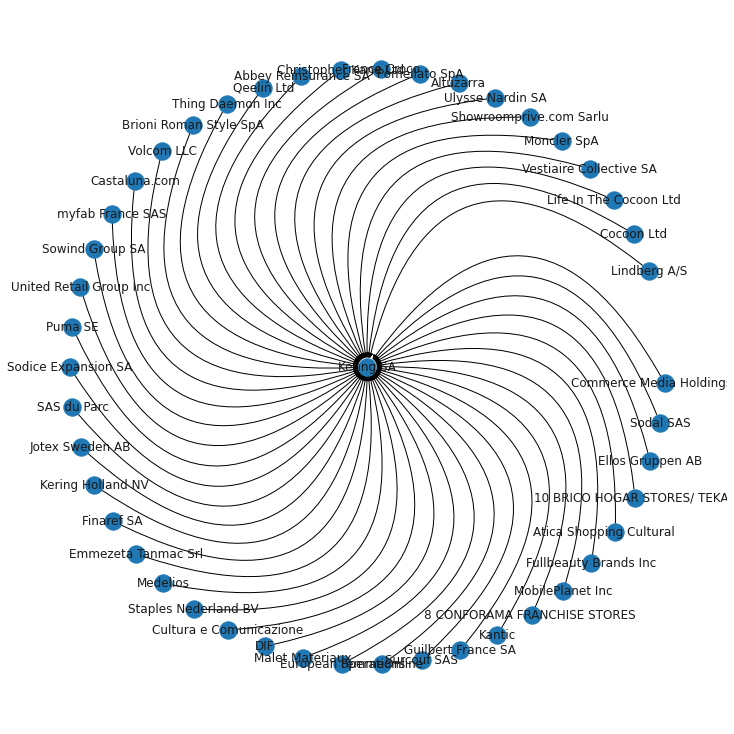

In [ ]:
 # Advice Network
colors = nx.get_edge_attributes(dig, 'color').values()
plt.figure(figsize=(10,10))
nx.draw_kamada_kawai(dig, with_labels = True, connectionstyle='arc3, rad = 0.8', edge_color=colors)

In [ ]:
#density
print(nx.density(dig))

0.021739130434782608


In [ ]:
#Since we are looking for 'wanted friend' and 'advice giver', we analyse out_degree centrality.
cent_degree = dict(dig.out_degree) 

In [ ]:
 nx.set_node_attributes(dig, cent_degree, 'cent_degree')

In [ ]:
#create and save a layout.
G_layout = nx.layout.kamada_kawai_layout(dig)

In [130]:
#Plot for advice netwok
dig_plot = hv.Graph.from_networkx(dig, G_layout).opts(tools=['hover'], directed=True, edge_alpha=0.1, node_size='cent_degree', legend_position='right' )
labels = hv.Labels(dig_plot.nodes, ['x', 'y'], 'index')

show(hv.render(dig_plot * labels.opts(text_font_size='6pt', text_color='black', bgcolor='white')))

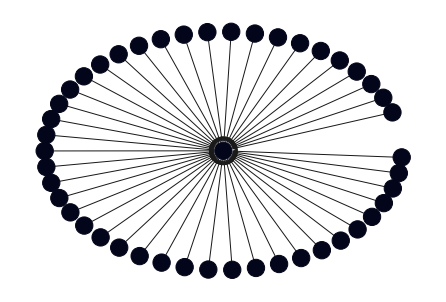

In [ ]:
dig_und = nx.to_undirected(dig)
partition = community_louvain.best_partition(dig_und) 
nx.set_node_attributes(dig, partition, 'partition') 
nx.draw_kamada_kawai(dig, node_color=list(partition.values()))